In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

Rmatrix_train_csv = pd.read_csv("https://raw.githubusercontent.com/Jaeik-Jeong/AnoAutoRec/main/UI_Matrix_100k_Train.csv", index_col=0)
Rmatrix_csv       = pd.read_csv("https://raw.githubusercontent.com/Jaeik-Jeong/AnoAutoRec/main/UI_Matrix_100k_All.csv", index_col=0)
Rmatrix_train_csv = Rmatrix_train_csv.replace(np.nan, 0)
Rmatrix_csv       = Rmatrix_csv.replace(np.nan, 0)

Rmatrix_train = np.array(Rmatrix_train_csv)
Rmatrix       = np.array(Rmatrix_csv)

Bmatrix_train = np.where(Rmatrix_train > 0, 1, 0)
Bmatrix = np.where(Rmatrix > 0, 1, 0)

num_user  = len(Rmatrix_csv.index)
num_movie = len(Rmatrix_csv.columns)

In [ ]:
class AE(nn.Module):
    def __init__(self, ):
        super(AE, self).__init__()
        self.fc1 = nn.Linear(num_movie, 16)
        self.fc2 = nn.Linear(16, num_movie)
        #self.activation = nn.ReLU()
        self.activation = nn.Sigmoid()
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        y = self.fc2(x)
        return x, y

In [ ]:
ae = AE()
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr = 0.001, weight_decay = 0.1)
training_set = torch.FloatTensor(Rmatrix_train)/5
test_set = torch.FloatTensor(Rmatrix)/5

for epoch in range(1, 41):
    train_loss = 0
    test_loss = 0
    train_s = 0.
    test_s = 0.

    for i in range(num_user):
        input = Variable(training_set[i]).unsqueeze(0)
        target1 = input.clone()
        target2 = Variable(test_set[i]).unsqueeze(0)
        if torch.sum(target1.data > 0) > 0:
            output1 = ae(input)[1]
            target1.require_grad = False
            output1[target1 == 0] = 0
            loss1 = criterion(output1, target1)
            loss1.backward()

            output2 = ae(input)[1]
            output2[target2 == input] = input[target2 == input]
            loss2 = criterion(output2, target2)

            mean_corrector1 = num_movie/float(torch.sum(target1.data > 0))
            train_loss += 5*np.sqrt(loss1.data.tolist()*mean_corrector1)
            train_s += 1.
            if float(torch.sum(target2.data != input.data)) > 0:
                mean_corrector2 = num_movie/float(torch.sum(target2.data != input.data))
                test_loss += 5*np.sqrt(loss2.data.tolist()*mean_corrector2)
                test_s += 1.
            optimizer.step()
    print('epoch: '+str(epoch)+' train_loss: '+str(round(train_loss/train_s,4))+' test_loss: '+str(round(test_loss/test_s,4)))

epoch: 1 train_loss: 1.6836 test_loss: 2.2553
epoch: 2 train_loss: 1.0662 test_loss: 1.0861
epoch: 3 train_loss: 1.0358 test_loss: 1.051
epoch: 4 train_loss: 1.0187 test_loss: 1.0345
epoch: 5 train_loss: 1.0065 test_loss: 1.0241
epoch: 6 train_loss: 0.9966 test_loss: 1.0163
epoch: 7 train_loss: 0.988 test_loss: 1.0099
epoch: 8 train_loss: 0.9802 test_loss: 1.0043
epoch: 9 train_loss: 0.9733 test_loss: 0.9993
epoch: 10 train_loss: 0.9672 test_loss: 0.9951
epoch: 11 train_loss: 0.9617 test_loss: 0.9914
epoch: 12 train_loss: 0.9566 test_loss: 0.9882
epoch: 13 train_loss: 0.952 test_loss: 0.9853
epoch: 14 train_loss: 0.9476 test_loss: 0.9828
epoch: 15 train_loss: 0.9436 test_loss: 0.9806
epoch: 16 train_loss: 0.9398 test_loss: 0.9786
epoch: 17 train_loss: 0.9361 test_loss: 0.9768
epoch: 18 train_loss: 0.9324 test_loss: 0.9751
epoch: 19 train_loss: 0.9289 test_loss: 0.9735
epoch: 20 train_loss: 0.9253 test_loss: 0.972
epoch: 21 train_loss: 0.9218 test_loss: 0.9706
epoch: 22 train_loss: 0.91

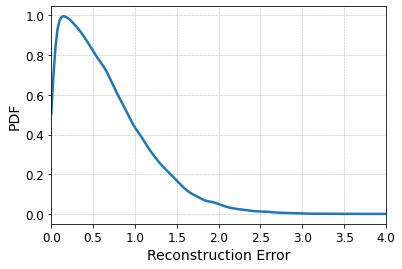

In [ ]:
training_in = Rmatrix_train/5

for i in range(num_user):
    input = Variable(training_set[i]).unsqueeze(0)
    output = ae(input)[1]
    output[input == 0] = 0

    if i == 0: training_out = output.detach().numpy()
    else: training_out = np.append(training_out, output.detach().numpy(), axis=0)

train_loss_mat = 5*np.abs(training_in - training_out)
train_loss_list = []
for i in range(len(train_loss_mat)):
    for j in range(len(train_loss_mat[0])):
        if train_loss_mat[i][j] != 0:
            train_loss_list += [train_loss_mat[i][j]]

xs = np.linspace(0.0, 5.0, 200)
pdf_pred = gaussian_kde(train_loss_list)
fig_pdf = plt.figure()
plt.plot(xs, pdf_pred(xs), linewidth=2.5)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Reconstruction Error", fontsize=14)
plt.ylabel("PDF", fontsize=14)
plt.xlim([0,4])
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
Rmatrix_train_pre = Rmatrix_train.copy()
Rmatrix_pre = Rmatrix.copy()

Cat_user  = np.zeros((num_user, num_movie))
Cat_movie = np.zeros((num_user, num_movie))

for i in range(num_user):
    Weak_user    = list(Rmatrix_train[i]).count(1) >= list(Rmatrix_train[i]).count(2) + list(Rmatrix_train[i]).count(3) + list(Rmatrix_train[i]).count(4) + list(Rmatrix_train[i]).count(5)
    Average_user = list(Rmatrix_train[i]).count(2) + list(Rmatrix_train[i]).count(3) >= list(Rmatrix_train[i]).count(1) + list(Rmatrix_train[i]).count(4) + list(Rmatrix_train[i]).count(5)
    Strong_user  = list(Rmatrix_train[i]).count(4) + list(Rmatrix_train[i]).count(5) >= list(Rmatrix_train[i]).count(1) + list(Rmatrix_train[i]).count(2) + list(Rmatrix_train[i]).count(3)
    if Weak_user:    Cat_user[i] = np.array([1 for _ in range(num_movie)])
    if Average_user: Cat_user[i] = np.array([10 for _ in range(num_movie)])
    if Strong_user:  Cat_user[i] = np.array([100 for _ in range(num_movie)])

for j in range(num_movie):
    Weak_movie    = list(Rmatrix_train[:,j]).count(1) >= list(Rmatrix_train[:,j]).count(2) + list(Rmatrix_train[:,j]).count(3) + list(Rmatrix_train[:,j]).count(4) + list(Rmatrix_train[:,j]).count(5)
    Average_movie = list(Rmatrix_train[:,j]).count(2) + list(Rmatrix_train[:,j]).count(3) >= list(Rmatrix_train[:,j]).count(1) + list(Rmatrix_train[:,j]).count(4) + list(Rmatrix_train[:,j]).count(5)
    Strong_movie  = list(Rmatrix_train[:,j]).count(4) + list(Rmatrix_train[:,j]).count(5) >= list(Rmatrix_train[:,j]).count(1) + list(Rmatrix_train[:,j]).count(2) + list(Rmatrix_train[:,j]).count(3)
    if Weak_movie:    Cat_movie[:,j] = np.array([1 for _ in range(num_user)])
    if Average_movie: Cat_movie[:,j] = np.array([10 for _ in range(num_user)])
    if Strong_movie:  Cat_movie[:,j] = np.array([100 for _ in range(num_user)])

Cat_rating = Cat_user+Cat_movie
for i in range(num_user):
    for j in range(num_movie):
        if Cat_rating[i][j] == 2 and Rmatrix_train[i][j] >= 2:
            Rmatrix_train_pre[i][j] = 0; Rmatrix_pre[i][j] = 0
        if Cat_rating[i][j] == 20 and 0 < Rmatrix_train[i][j] < 2:
            Rmatrix_train_pre[i][j] = 0; Rmatrix_pre[i][j] = 0
        if Cat_rating[i][j] == 20 and Rmatrix_train[i][j] >= 4:
            Rmatrix_train_pre[i][j] = 0; Rmatrix_pre[i][j] = 0
        if Cat_rating[i][j] == 200 and 0 < Rmatrix_train[i][j] < 4:
            Rmatrix_train_pre[i][j] = 0; Rmatrix_pre[i][j] = 0

In [ ]:
ae_cat = AE()
optimizer_cat = optim.Adam(ae_cat.parameters(), lr = 0.001, weight_decay = 0.1)
training_set_pre = torch.FloatTensor(Rmatrix_train_pre)/5
test_set_pre = torch.FloatTensor(Rmatrix_pre)/5

for epoch in range(1, 51):
    train_loss = 0
    test_loss = 0
    train_s = 0.
    test_s = 0.

    for i in range(num_user):
        input = Variable(training_set_pre[i]).unsqueeze(0)
        target1 = input.clone()
        target2 = Variable(test_set_pre[i]).unsqueeze(0)
        if torch.sum(target1.data > 0) > 0:
            output1 = ae_cat(input)[1]
            target1.require_grad = False
            output1[target1 == 0] = 0
            loss1 = criterion(output1, target1)
            loss1.backward()

            output2 = ae_cat(input)[1]
            output2[target2 == input] = input[target2 == input]
            loss2 = criterion(output2, target2)

            mean_corrector1 = num_movie/float(torch.sum(target1.data > 0))
            train_loss += 5*np.sqrt(loss1.data.tolist()*mean_corrector1)
            train_s += 1.
            if float(torch.sum(target2.data != input.data)) > 0:
                mean_corrector2 = num_movie/float(torch.sum(target2.data != input.data))
                test_loss += 5*np.sqrt(loss2.data.tolist()*mean_corrector2)
                test_s += 1.
            optimizer_cat.step()
    print('epoch: '+str(epoch)+' train_loss: '+str(round(train_loss/train_s,4))+' test_loss: '+str(round(test_loss/test_s,4)))

epoch: 1 train_loss: 1.7022 test_loss: 2.2853
epoch: 2 train_loss: 0.9908 test_loss: 1.0853
epoch: 3 train_loss: 0.9466 test_loss: 1.0526
epoch: 4 train_loss: 0.9229 test_loss: 1.0403
epoch: 5 train_loss: 0.9069 test_loss: 1.0336
epoch: 6 train_loss: 0.8951 test_loss: 1.0295
epoch: 7 train_loss: 0.8857 test_loss: 1.0262
epoch: 8 train_loss: 0.8778 test_loss: 1.023
epoch: 9 train_loss: 0.8709 test_loss: 1.0197
epoch: 10 train_loss: 0.8647 test_loss: 1.0165
epoch: 11 train_loss: 0.8591 test_loss: 1.0134
epoch: 12 train_loss: 0.854 test_loss: 1.0105
epoch: 13 train_loss: 0.8493 test_loss: 1.008
epoch: 14 train_loss: 0.845 test_loss: 1.0057
epoch: 15 train_loss: 0.8411 test_loss: 1.0037
epoch: 16 train_loss: 0.8373 test_loss: 1.0018
epoch: 17 train_loss: 0.8338 test_loss: 1.0001
epoch: 18 train_loss: 0.8304 test_loss: 0.9986
epoch: 19 train_loss: 0.8272 test_loss: 0.9971
epoch: 20 train_loss: 0.824 test_loss: 0.9958
epoch: 21 train_loss: 0.821 test_loss: 0.9946
epoch: 22 train_loss: 0.818 

In [ ]:
Rmatrix_train_pre2 = Rmatrix_train.copy()
Rmatrix_pre2 = Rmatrix.copy()

for i in range(num_user):
    for j in range(num_movie):
        if Cat_rating[i][j] == 2 and Rmatrix_train[i][j] >= 2:
            Rmatrix_train_pre2[i][j] = 1; Rmatrix_pre2[i][j] = 1
        if Cat_rating[i][j] == 20 and 0 < Rmatrix_train[i][j] < 2:
            Rmatrix_train_pre2[i][j] = 2.5; Rmatrix_pre2[i][j] = 2.5
        if Cat_rating[i][j] == 20 and Rmatrix_train[i][j] >= 4:
            Rmatrix_train_pre2[i][j] = 2.5; Rmatrix_pre2[i][j] = 2.5
        if Cat_rating[i][j] == 200 and 0 < Rmatrix_train[i][j] < 4:
            Rmatrix_train_pre2[i][j] = 4.5; Rmatrix_pre2[i][j] = 4.5

In [ ]:
ae_cat2 = AE()
optimizer_cat2 = optim.Adam(ae_cat2.parameters(), lr = 0.001, weight_decay = 0.1)
training_set_pre2 = torch.FloatTensor(Rmatrix_train_pre2)/5
test_set_pre2 = torch.FloatTensor(Rmatrix_pre2)/5

for epoch in range(1, 51):
    train_loss = 0
    test_loss = 0
    train_s = 0.
    test_s = 0.

    for i in range(num_user):
        input = Variable(training_set_pre2[i]).unsqueeze(0)
        target1 = input.clone()
        target2 = Variable(test_set_pre2[i]).unsqueeze(0)
        if torch.sum(target1.data > 0) > 0:
            output1 = ae_cat2(input)[1]
            target1.require_grad = False
            output1[target1 == 0] = 0
            loss1 = criterion(output1, target1)
            loss1.backward()

            output2 = ae_cat2(input)[1]
            output2[target2 == input] = input[target2 == input]
            loss2 = criterion(output2, target2)

            mean_corrector1 = num_movie/float(torch.sum(target1.data > 0))
            train_loss += 5*np.sqrt(loss1.data.tolist()*mean_corrector1)
            train_s += 1.
            if float(torch.sum(target2.data != input.data)) > 0:
                mean_corrector2 = num_movie/float(torch.sum(target2.data != input.data))
                test_loss += 5*np.sqrt(loss2.data.tolist()*mean_corrector2)
                test_s += 1.
            optimizer_cat2.step()
    print('epoch: '+str(epoch)+' train_loss: '+str(round(train_loss/train_s,4))+' test_loss: '+str(round(test_loss/test_s,4)))

epoch: 1 train_loss: 1.6285 test_loss: 2.2107
epoch: 2 train_loss: 0.9436 test_loss: 1.0866
epoch: 3 train_loss: 0.9053 test_loss: 1.0604
epoch: 4 train_loss: 0.8838 test_loss: 1.0494
epoch: 5 train_loss: 0.869 test_loss: 1.0426
epoch: 6 train_loss: 0.8579 test_loss: 1.0378
epoch: 7 train_loss: 0.8491 test_loss: 1.0342
epoch: 8 train_loss: 0.8415 test_loss: 1.0311
epoch: 9 train_loss: 0.8348 test_loss: 1.0283
epoch: 10 train_loss: 0.8286 test_loss: 1.0257
epoch: 11 train_loss: 0.8229 test_loss: 1.0233
epoch: 12 train_loss: 0.8177 test_loss: 1.0212
epoch: 13 train_loss: 0.8129 test_loss: 1.0193
epoch: 14 train_loss: 0.8084 test_loss: 1.0175
epoch: 15 train_loss: 0.8043 test_loss: 1.0159
epoch: 16 train_loss: 0.8004 test_loss: 1.0145
epoch: 17 train_loss: 0.7968 test_loss: 1.0131
epoch: 18 train_loss: 0.7933 test_loss: 1.0119
epoch: 19 train_loss: 0.7901 test_loss: 1.0108
epoch: 20 train_loss: 0.7869 test_loss: 1.0098
epoch: 21 train_loss: 0.7839 test_loss: 1.0089
epoch: 22 train_loss: 0

In [ ]:
Rmatrix_train_new = Rmatrix_train_pre.copy()
Rmatrix_new = Rmatrix_pre.copy()

for i in range(len(train_loss_mat)):
    for j in range(len(train_loss_mat[0])):
        if train_loss_mat[i][j] > 1.5:
            Rmatrix_train_new[i][j] = 0
            Rmatrix_new[i][j] = 0

ae_main = AE()
optimizer_main = optim.Adam(ae_main.parameters(), lr = 0.001, weight_decay = 0.1)
training_set_new = torch.FloatTensor(Rmatrix_train_new)/5
test_set_new = torch.FloatTensor(Rmatrix_new)/5

for epoch in range(1, 61):
    train_loss = 0
    test_loss = 0
    train_s = 0.
    test_s = 0.

    for i in range(num_user):
        input = Variable(training_set_new[i]).unsqueeze(0)
        target1 = input.clone()
        target2 = Variable(test_set_new[i]).unsqueeze(0)
        if torch.sum(target1.data > 0) > 0:
            output1 = ae_main(input)[1]
            target1.require_grad = False
            output1[target1 == 0] = 0
            loss1 = criterion(output1, target1)
            loss1.backward()

            output2 = ae_main(input)[1]
            output2[target2 == input] = input[target2 == input]
            loss2 = criterion(output2, target2)

            mean_corrector1 = num_movie/float(torch.sum(target1.data > 0))
            train_loss += 5*np.sqrt(loss1.data.tolist()*mean_corrector1)
            train_s += 1.
            if float(torch.sum(target2.data != input.data)) > 0:
                mean_corrector2 = num_movie/float(torch.sum(target2.data != input.data))
                test_loss += 5*np.sqrt(loss2.data.tolist()*mean_corrector2)
                test_s += 1.
            optimizer_main.step()
    print('epoch: '+str(epoch)+' train_loss: '+str(round(train_loss/train_s,4))+' test_loss: '+str(round(test_loss/test_s,4)))

epoch: 1 train_loss: 1.6607 test_loss: 2.3397
epoch: 2 train_loss: 0.8817 test_loss: 1.0859
epoch: 3 train_loss: 0.8316 test_loss: 1.0515
epoch: 4 train_loss: 0.8059 test_loss: 1.0389
epoch: 5 train_loss: 0.789 test_loss: 1.0321
epoch: 6 train_loss: 0.7764 test_loss: 1.0278
epoch: 7 train_loss: 0.766 test_loss: 1.0245
epoch: 8 train_loss: 0.757 test_loss: 1.0215
epoch: 9 train_loss: 0.7491 test_loss: 1.0185
epoch: 10 train_loss: 0.742 test_loss: 1.0157
epoch: 11 train_loss: 0.7357 test_loss: 1.0133
epoch: 12 train_loss: 0.7301 test_loss: 1.0112
epoch: 13 train_loss: 0.725 test_loss: 1.0094
epoch: 14 train_loss: 0.7204 test_loss: 1.0077
epoch: 15 train_loss: 0.7162 test_loss: 1.0061
epoch: 16 train_loss: 0.7122 test_loss: 1.0046
epoch: 17 train_loss: 0.7084 test_loss: 1.0032
epoch: 18 train_loss: 0.7048 test_loss: 1.0018
epoch: 19 train_loss: 0.7013 test_loss: 1.0006
epoch: 20 train_loss: 0.698 test_loss: 0.9993
epoch: 21 train_loss: 0.6948 test_loss: 0.9982
epoch: 22 train_loss: 0.6917

In [ ]:
test_in = Rmatrix/5
test_set = torch.FloatTensor(Rmatrix)/5

for i in range(num_user):
    input = Variable(training_set[i]).unsqueeze(0)
    target = Variable(test_set[i]).unsqueeze(0)
    output = ae(input)[1]
    output[target == input] = input[target == input]

    if i == 0: test_out = output.detach().numpy()
    else: test_out = np.append(test_out, output.detach().numpy(), axis=0)

test_loss_mat = np.abs(test_in - test_out)
test_list = {}; test_list['user'] = []; test_list['real'] = []; test_list['pred'] = []; test_list['loss'] = []
for i in range(len(test_loss_mat)):
    for j in range(len(test_loss_mat[0])):
        if test_loss_mat[i][j] > 1e-7:
            test_list['user'] += [i]
            test_list['real'] += [5*test_in[i][j]]
            test_list['pred'] += [5*test_out[i][j]]
            test_list['loss'] += [5*test_loss_mat[i][j]]
test_list = pd.DataFrame(test_list)



test_in_pre = Rmatrix_pre/5
test_set_pre = torch.FloatTensor(Rmatrix_pre)/5

for i in range(num_user):
    input = Variable(training_set_pre[i]).unsqueeze(0)
    target = Variable(test_set_pre[i]).unsqueeze(0)
    output = ae_cat(input)[1]
    output[target == input] = input[target == input]

    if i == 0: test_out_pre = output.detach().numpy()
    else: test_out_pre = np.append(test_out_pre, output.detach().numpy(), axis=0)

test_loss_mat2 = np.abs(test_in_pre - test_out_pre)
test_list2 = {}; test_list2['user'] = []; test_list2['real'] = []; test_list2['pred'] = []; test_list2['loss'] = []
for i in range(len(test_loss_mat2)):
    for j in range(len(test_loss_mat2[0])):
        if test_loss_mat2[i][j] > 1e-7:
            test_list2['user'] += [i]
            test_list2['real'] += [5*test_in_pre[i][j]]
            test_list2['pred'] += [5*test_out_pre[i][j]]
            test_list2['loss'] += [5*test_loss_mat2[i][j]]
test_list2 = pd.DataFrame(test_list2)



test_in_pre2 = Rmatrix_pre2/5
test_set_pre2 = torch.FloatTensor(Rmatrix_pre2)/5

for i in range(num_user):
    input = Variable(training_set_pre2[i]).unsqueeze(0)
    target = Variable(test_set_pre2[i]).unsqueeze(0)
    output = ae_cat2(input)[1]
    output[target == input] = input[target == input]

    if i == 0: test_out_pre2 = output.detach().numpy()
    else: test_out_pre2 = np.append(test_out_pre2, output.detach().numpy(), axis=0)

test_loss_mat22 = np.abs(test_in_pre2 - test_out_pre2)
test_list22 = {}; test_list22['user'] = []; test_list22['real'] = []; test_list22['pred'] = []; test_list22['loss'] = []
for i in range(len(test_loss_mat22)):
    for j in range(len(test_loss_mat22[0])):
        if test_loss_mat22[i][j] > 1e-7:
            test_list22['user'] += [i]
            test_list22['real'] += [5*test_in_pre2[i][j]]
            test_list22['pred'] += [5*test_out_pre2[i][j]]
            test_list22['loss'] += [5*test_loss_mat22[i][j]]
test_list22 = pd.DataFrame(test_list22)



test_in_new = Rmatrix_new/5
test_set_new = torch.FloatTensor(Rmatrix_new)/5

for i in range(num_user):
    input = Variable(training_set_new[i]).unsqueeze(0)
    target = Variable(test_set_new[i]).unsqueeze(0)
    output = ae_main(input)[1]
    output[target == input] = input[target == input]

    if i == 0: test_out_new = output.detach().numpy()
    else: test_out_new = np.append(test_out_new, output.detach().numpy(), axis=0)

test_loss_mat3 = np.abs(test_in_new - test_out_new)
test_list3 = {}; test_list3['user'] = []; test_list3['real'] = []; test_list3['pred'] = []; test_list3['loss'] = []
for i in range(len(test_loss_mat3)):
    for j in range(len(test_loss_mat3[0])):
        if test_loss_mat3[i][j] > 1e-7:
            test_list3['user'] += [i]
            test_list3['real'] += [5*test_in_new[i][j]]
            test_list3['pred'] += [5*test_out_new[i][j]]
            test_list3['loss'] += [5*test_loss_mat3[i][j]]
test_list3 = pd.DataFrame(test_list3)

ratio low rank: 0.6
test RMSE1: 0.4497, test MAE1: 0.3853
test RMSE2: 0.4326, test MAE2: 0.3697
test RMSE22: 0.4401, test MAE22: 0.3747
test RMSE3: 0.425, test MAE3: 0.3636
----------------------------------------
ratio low rank: 0.7
test RMSE1: 0.5379, test MAE1: 0.4588
test RMSE2: 0.5203, test MAE2: 0.4422
test RMSE22: 0.5296, test MAE22: 0.4488
test RMSE3: 0.5121, test MAE3: 0.4353
----------------------------------------
ratio low rank: 0.8
test RMSE1: 0.6358, test MAE1: 0.5387
test RMSE2: 0.6182, test MAE2: 0.5215
test RMSE22: 0.6294, test MAE22: 0.5297
test RMSE3: 0.6113, test MAE3: 0.5149
----------------------------------------
ratio low rank: 0.9
test RMSE1: 0.7558, test MAE1: 0.6319
test RMSE2: 0.7398, test MAE2: 0.6149
test RMSE22: 0.7519, test MAE22: 0.6243
test RMSE3: 0.7367, test MAE3: 0.6102
----------------------------------------
ratio low rank: 1
test RMSE1: 0.961, test MAE1: 0.7673
test RMSE2: 0.9704, test MAE2: 0.7606
test RMSE22: 0.9825, test MAE22: 0.7708
test RMS

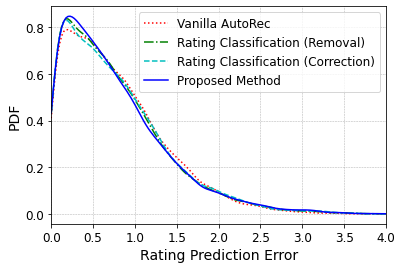

In [ ]:
def RMSE(x):
    y = 0
    for i in range(len(x)):
        y += x[i]*x[i]
    y = np.sqrt(y/len(x))
    return y

test_list_sort = test_list.sort_values(by=["loss"], ascending=[True])
test_list_sort2 = test_list2.sort_values(by=["loss"], ascending=[True])
test_list_sort22 = test_list22.sort_values(by=["loss"], ascending=[True])
test_list_sort3 = test_list3.sort_values(by=["loss"], ascending=[True])

ratio_low_rank = [0.6, 0.7, 0.8, 0.9, 1]
RMSE_list1 = []; RMSE_list2 = []; RMSE_list22 = []; RMSE_list3 = []
MAE_list1 = []; MAE_list2 = []; MAE_list22 = []; MAE_list3 = []
for r in ratio_low_rank:
    print('ratio low rank: '+str(r))
    num_high_rank = int(len(test_list_sort['loss'])*(1-r)); num_low_rank = int(len(test_list_sort['loss'])*r)

    RMSE_list1 += [RMSE(np.array(test_list_sort['loss'])[:num_low_rank])]
    MAE_list1 += [np.mean(np.array(test_list_sort['loss'])[:num_low_rank])]
    print('test RMSE1: '+str(round(RMSE_list1[-1],4))+', test MAE1: '+str(round(MAE_list1[-1],4)))
    
    RMSE_list2 += [RMSE(np.array(test_list_sort2['loss'])[:num_low_rank])]
    MAE_list2 += [np.mean(np.array(test_list_sort2['loss'])[:num_low_rank])]
    print('test RMSE2: '+str(round(RMSE_list2[-1],4))+', test MAE2: '+str(round(MAE_list2[-1],4)))

    RMSE_list22 += [RMSE(np.array(test_list_sort22['loss'])[:num_low_rank])]
    MAE_list22 += [np.mean(np.array(test_list_sort22['loss'])[:num_low_rank])]
    print('test RMSE22: '+str(round(RMSE_list22[-1],4))+', test MAE22: '+str(round(MAE_list22[-1],4)))
    
    RMSE_list3 += [RMSE(np.array(test_list_sort3['loss'])[:num_low_rank])]
    MAE_list3 += [np.mean(np.array(test_list_sort3['loss'])[:num_low_rank])]
    print('test RMSE3: '+str(round(RMSE_list3[-1],4))+', test MAE3: '+str(round(MAE_list3[-1],4)))
    print('----------------------------------------')

xs = np.linspace(0.0, 5.0, 200)
pdf_pred = gaussian_kde(test_list_sort['loss'])
pdf_pred2 = gaussian_kde(test_list_sort2['loss'])
pdf_pred22 = gaussian_kde(test_list_sort22['loss'])
pdf_pred3 = gaussian_kde(test_list_sort3['loss'])
fig_pdf = plt.figure()
plt.plot(xs, pdf_pred(xs), "r:", linewidth=1.5, label="Vanilla AutoRec")
plt.plot(xs, pdf_pred2(xs), "g-.", linewidth=1.5, label="Rating Classification (Removal)")
plt.plot(xs, pdf_pred22(xs), "c--", linewidth=1.5, label="Rating Classification (Correction)")
plt.plot(xs, pdf_pred3(xs), "b", linewidth=1.5, label="Proposed Method")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Rating Prediction Error", fontsize=14)
plt.ylabel("PDF", fontsize=14)
plt.xlim([0,4])
plt.grid(linestyle='--', linewidth=0.5)
plt.legend(fontsize=12, loc=1)
plt.show()

In [ ]:
def BIN(real,pred):
    tp_num = 0; fp_num = 0; fn_num = 0; tn_num = 0
    for i in range(len(real)):
        if real[i] == 1 and pred[i] == 1:
            tp_num += 1
        if real[i] == 0 and pred[i] == 1:
            fp_num += 1
        if real[i] == 1 and pred[i] == 0:
            fn_num += 1
        if real[i] == 0 and pred[i] == 0:
            tn_num += 1
    return tp_num, fp_num, fn_num, tn_num

test_list_bin = test_list.copy()
test_list_bin2 = test_list2.copy()
test_list_bin22 = test_list22.copy()
test_list_bin3 = test_list3.copy()

threshold_rate = 3.5
test_list_bin.loc[test_list_bin['real'] < threshold_rate, 'real'] = 0
test_list_bin.loc[test_list_bin['real'] > threshold_rate, 'real'] = 1
test_list_bin.loc[test_list_bin['pred'] < threshold_rate, 'pred'] = 0
test_list_bin.loc[test_list_bin['pred'] > threshold_rate, 'pred'] = 1
test_list_bin['loss'] = np.abs(np.array(test_list_bin['real']) - np.array(test_list_bin['pred'])).tolist()
test_list_bin2.loc[test_list_bin2['real'] < threshold_rate, 'real'] = 0
test_list_bin2.loc[test_list_bin2['real'] > threshold_rate, 'real'] = 1
test_list_bin2.loc[test_list_bin2['pred'] < threshold_rate, 'pred'] = 0
test_list_bin2.loc[test_list_bin2['pred'] > threshold_rate, 'pred'] = 1
test_list_bin2['loss'] = np.abs(np.array(test_list_bin2['real']) - np.array(test_list_bin2['pred'])).tolist()
test_list_bin22.loc[test_list_bin22['real'] < threshold_rate, 'real'] = 0
test_list_bin22.loc[test_list_bin22['real'] > threshold_rate, 'real'] = 1
test_list_bin22.loc[test_list_bin22['pred'] < threshold_rate, 'pred'] = 0
test_list_bin22.loc[test_list_bin22['pred'] > threshold_rate, 'pred'] = 1
test_list_bin22['loss'] = np.abs(np.array(test_list_bin22['real']) - np.array(test_list_bin22['pred'])).tolist()
test_list_bin3.loc[test_list_bin3['real'] < threshold_rate, 'real'] = 0
test_list_bin3.loc[test_list_bin3['real'] > threshold_rate, 'real'] = 1
test_list_bin3.loc[test_list_bin3['pred'] < threshold_rate, 'pred'] = 0
test_list_bin3.loc[test_list_bin3['pred'] > threshold_rate, 'pred'] = 1
test_list_bin3['loss'] = np.abs(np.array(test_list_bin3['real']) - np.array(test_list_bin3['pred'])).tolist()

test_list_bin_sort = test_list_bin.sort_values(by=["loss"], ascending=[True])
test_list_bin_sort2 = test_list_bin2.sort_values(by=["loss"], ascending=[True])
test_list_bin_sort22 = test_list_bin22.sort_values(by=["loss"], ascending=[True])
test_list_bin_sort3 = test_list_bin3.sort_values(by=["loss"], ascending=[True])

ratio_low_rank = [0.6, 0.7, 0.8, 0.9, 1]
PREC_list1 = []; PREC_list2 = []; PREC_list22 = []; PREC_list3 = []
REC_list1 = []; REC_list2 = []; REC_list22 = []; REC_list3 = []
F_list1 = []; F_list2 = []; F_list22 = []; F_list3 = []
ACC_list1 = []; ACC_list2 = []; ACC_list22 = []; ACC_list3 = []
for r in ratio_low_rank:
    print('ratio low rank: '+str(r))
    num_high_rank = int(len(test_list_bin_sort['loss'])*(1-r)); num_low_rank = int(len(test_list_bin_sort['loss'])*r)

    BIN1 = BIN(np.array(test_list_bin_sort['real'])[:num_low_rank], np.array(test_list_bin_sort['pred'])[:num_low_rank])
    PREC_list1 += [BIN1[0]/(BIN1[0]+BIN1[1])]
    REC_list1 += [BIN1[0]/(BIN1[0]+BIN1[2])]
    ACC_list1 += [(BIN1[0]+BIN1[3])/(BIN1[0]+BIN1[1]+BIN1[2]+BIN1[3])]
    F_list1 += [(2*PREC_list1[-1]*REC_list1[-1])/(PREC_list1[-1]+REC_list1[-1])]
    print('test PREC1: '+str(round(PREC_list1[-1],4))+', test REC1: '+str(round(REC_list1[-1],4))
          +', test F1: '+str(round(F_list1[-1],4))+', test ACC1: '+str(round(ACC_list1[-1],4)))
    
    BIN2 = BIN(np.array(test_list_bin_sort2['real'])[:num_low_rank], np.array(test_list_bin_sort2['pred'])[:num_low_rank])
    PREC_list2 += [BIN2[0]/(BIN2[0]+BIN2[1])]
    REC_list2 += [BIN2[0]/(BIN2[0]+BIN2[2])]
    ACC_list2 += [(BIN2[0]+BIN2[3])/(BIN2[0]+BIN2[1]+BIN2[2]+BIN2[3])]
    F_list2 += [(2*PREC_list2[-1]*REC_list2[-1])/(PREC_list2[-1]+REC_list2[-1])]
    print('test PREC2: '+str(round(PREC_list2[-1],4))+', test REC2: '+str(round(REC_list2[-1],4))
          +', test F2: '+str(round(F_list2[-1],4))+', test ACC2: '+str(round(ACC_list2[-1],4)))
    
    BIN22 = BIN(np.array(test_list_bin_sort22['real'])[:num_low_rank], np.array(test_list_bin_sort22['pred'])[:num_low_rank])
    PREC_list22 += [BIN22[0]/(BIN22[0]+BIN22[1])]
    REC_list22 += [BIN22[0]/(BIN22[0]+BIN22[2])]
    ACC_list22 += [(BIN22[0]+BIN22[3])/(BIN22[0]+BIN22[1]+BIN22[2]+BIN22[3])]
    F_list22 += [(2*PREC_list22[-1]*REC_list22[-1])/(PREC_list22[-1]+REC_list22[-1])]
    print('test PREC22: '+str(round(PREC_list22[-1],4))+', test REC22: '+str(round(REC_list22[-1],4))
          +', test F22: '+str(round(F_list22[-1],4))+', test ACC22: '+str(round(ACC_list22[-1],4)))

    BIN3 = BIN(np.array(test_list_bin_sort3['real'])[:num_low_rank], np.array(test_list_bin_sort3['pred'])[:num_low_rank])
    PREC_list3 += [BIN3[0]/(BIN3[0]+BIN3[1])]
    REC_list3 += [BIN3[0]/(BIN3[0]+BIN3[2])]
    ACC_list3 += [(BIN3[0]+BIN3[3])/(BIN3[0]+BIN3[1]+BIN3[2]+BIN3[3])]
    F_list3 += [(2*PREC_list3[-1]*REC_list3[-1])/(PREC_list3[-1]+REC_list3[-1])]
    print('test PREC3: '+str(round(PREC_list3[-1],4))+', test REC3: '+str(round(REC_list3[-1],4))
          +', test F3: '+str(round(F_list3[-1],4))+', test ACC3: '+str(round(ACC_list3[-1],4)))
    print('----------------------------------------------------------------------------------------------------')

ratio low rank: 0.6
test PREC1: 1.0, test REC1: 1.0, test F1: 1.0, test ACC1: 1.0
test PREC2: 1.0, test REC2: 1.0, test F2: 1.0, test ACC2: 1.0
test PREC22: 1.0, test REC22: 1.0, test F22: 1.0, test ACC22: 1.0
test PREC3: 1.0, test REC3: 1.0, test F3: 1.0, test ACC3: 1.0
----------------------------------------------------------------------------------------------------
ratio low rank: 0.7
test PREC1: 0.9988, test REC1: 0.9964, test F1: 0.9976, test ACC1: 0.9974
test PREC2: 1.0, test REC2: 1.0, test F2: 1.0, test ACC2: 1.0
test PREC22: 1.0, test REC22: 1.0, test F22: 1.0, test ACC22: 1.0
test PREC3: 1.0, test REC3: 1.0, test F3: 1.0, test ACC3: 1.0
----------------------------------------------------------------------------------------------------
ratio low rank: 0.8
test PREC1: 0.9057, test REC1: 0.8559, test F1: 0.8801, test ACC1: 0.8727
test PREC2: 0.9026, test REC2: 0.9124, test F2: 0.9075, test ACC2: 0.8909
test PREC22: 0.8979, test REC22: 0.9041, test F22: 0.901, test ACC22: 0.88

In [ ]:
torch.save(ae.state_dict(), 'ae_100k.pt')
torch.save(ae_cat.state_dict(), 'ae_cat_100k.pt')
torch.save(ae_cat2.state_dict(), 'ae_cat2_100k.pt')
torch.save(ae_main.state_dict(), 'ae_main_100k.pt')